## Exploritory Data Analysis of Seattle Pet License data set.

Use the API for the Seattle pet licence open data to get the breed and ZIP code location:

https://data.seattle.gov/Community/Seattle-Pet-Licenses/jguv-t9rb

Standard AKC breed names and characteristics can be found in this data set:

https://www.kaggle.com/datasets/paultimothymooney/best-in-show-data-about-dogs?resource=download

In [357]:
# Requests allows us to make HTTP requests which we will use to get data from an API
import requests
import pandas as pd
import numpy as np
# Datetime is a library that allows us to represent dates
import datetime
import json
import folium
# Import folium MarkerCluster plugin
from folium.plugins import MarkerCluster
# Import folium MousePosition plugin
from folium.plugins import MousePosition
# Import folium DivIcon plugin
from folium.features import DivIcon

import geopandas as gpd
# geopandas uses fiona to read/write files. No need to import fiona

# fuzzywuzzy is a fuzzy string match package
from fuzzywuzzy import fuzz
from fuzzywuzzy import process

import matplotlib.pyplot as plt

In [3]:
# Use API endpoint instead of downloading CSV
url=  'https://data.seattle.gov/resource/jguv-t9rb.json'
App_Token  = 'ooI5TiOD2Gls57XhqffGZykOU'


response = requests.get(url, params={'$$app_token':App_Token, 'species':'Dog', '$order':'license_number'})

In [12]:
response.headers

{'Server': 'nginx', 'Date': 'Sat, 25 Jun 2022 21:06:58 GMT', 'Content-Type': 'application/json;charset=utf-8', 'Transfer-Encoding': 'chunked', 'Connection': 'keep-alive', 'Access-Control-Allow-Origin': '*', 'ETag': '"YWxwaGEuMTYxMTcyXzJfNDV4Z2RZX0x3eHZuVTBMV2JqWUpUeDZzdnEtYzA---gzirwMp7vjEEoQeyOO4YddFDO-CAp3w--gzip--gzip"', 'X-SODA2-Fields': '["license_issue_date","license_number","animal_s_name","species","primary_breed","secondary_breed","zip_code"]', 'X-SODA2-Types': '["floating_timestamp","text","text","text","text","text","text"]', 'X-SODA2-Data-Out-Of-Date': 'false', 'X-SODA2-Truth-Last-Modified': 'Thu, 21 Apr 2022 19:57:44 GMT', 'X-SODA2-Secondary-Last-Modified': 'Thu, 21 Apr 2022 19:57:44 GMT', 'Last-Modified': 'Thu, 21 Apr 2022 19:57:44 GMT', 'Vary': 'Accept-Encoding', 'Content-Encoding': 'gzip', 'Age': '0', 'X-Socrata-Region': 'aws-us-east-1-fedramp-prod', 'Strict-Transport-Security': 'max-age=31536000; includeSubDomains', 'X-Socrata-RequestId': '73c533f8f34c01665b3945d32ec45

In [19]:
# Each request returns a limit of 1000 records unless specified in the request parameters
len(response.json())

1000

In [142]:
# Use json_normalize method to convert the json result into a dataframe
license_data = pd.json_normalize(response.json())
license_data.head()

,license_issue_date,license_number,animal_s_name,species,primary_breed,secondary_breed,zip_code
0,2020-12-15T00:00:00.000,108440,Pepe,Dog,Havanese,Mix,98125
1,2022-04-07T00:00:00.000,10912,Alfalfa,Dog,Terrier,Mix,98144
2,2021-03-12T00:00:00.000,114061,Lucy,Dog,"Terrier, Cairn",NaN,98112
3,2021-04-19T00:00:00.000,130498,Aster,Dog,"Terrier, Rat",NaN,98112
4,2021-04-21T00:00:00.000,131870,Lexie Lucile,Dog,Border Collie,NaN,98146


In [143]:
# Drop any rows with missing zip_code
license_data.dropna(axis=0,subset=['zip_code'],inplace=True)

# Convert zip_code from Object to int
license_data = license_data.astype({'zip_code': 'int64'})
distinct_zip = license_data['zip_code'].unique()

### Read best_in_show.xlsx

Get standardized AKC breed names, category, size category

In [62]:
path = 'E:/UserLo/source/repos/learning/Seattle Pets/'
file = 'best_in_show.xlsx'

# Load just the columns of interest
col_names = ['Dog breed','category','size category']
breed_data = pd.read_excel(path+file,sheet_name='best_in_show',header = 0, skiprows=[1], usecols=col_names)

In [40]:
breed_data.head()

,Dog breed,category,size category
0,Affenpinscher,toy,small
1,Afghan Hound,hound,large
2,Airedale Terrier,terrier,medium
3,Akita,working,large
4,Alaskan Malamute,working,large


Need to stardardize the primary_breed and secondary_breed to match the AKC Dog breed names so we can look up other AKC breed characteristics.

In [ ]:
pri_breed = license_data['primary_breed'].unique()
pri_breed

In [58]:
fuzz.token_set_ratio('Fox Wire Terrier','Fox Terrier – Wirehair')

89

In [19]:
AKC_name, match_ratio, breed_data_index = process.extractOne('Spaniel, English Springer', breed_data['Dog breed'], scorer=fuzz.token_set_ratio)
print (AKC_name,' ' , match_ratio, ' ' ,breed_data_index)

English Springer Spaniel   100   18


In [18]:
breed_data.iloc[18]

Dog breed           English Springer Spaniel
category                            sporting
POPULARITY IN US                        29.0
size category                         medium
Name: 18, dtype: object

In [64]:
def get_AKC_name (name,min_match_ratio = 90):
    AKC_name, match_ratio, breed_data_index = process.extractOne(name, breed_data['Dog breed'], scorer=fuzz.token_set_ratio)
    if match_ratio >= min_match_ratio :
        return (AKC_name)
    else:
        return (np.NaN)

In [161]:
# A match ratio of 70 seems to be a good tradeoff between accuracy and missing matches
license_data_AKC = license_data['primary_breed'].apply(get_AKC_name, args=(70,))

In [162]:
# Here are the primary_breed names that could not be matched with AKC names
license_data.iloc[license_data_AKC[license_data_AKC.isna()].index]['primary_breed'].unique()

array(['Retriever, Golden', 'Terrier, Cairn', 'Retriever, Labrador',
       'Chihuahua, Short Coat', 'German Shepherd', 'Maltese',
       'Spaniel, Tibetan', 'Boxer', 'Terrier, Fox, Toy', 'Poodle, Toy',
       'Havanese', 'Pug', 'Terrier, Jack Russell'], dtype=object)

In [163]:
# Add AKC names to license_data. Only a small percentage are not identified with AKC name
license_data['AKC name']= license_data_AKC
print(f"Ratio of dogs not identified with AKC breed name: {license_data[license_data['AKC name'].isna()]['license_number'].count()/license_data['license_number'].count()}")

Ratio of dogs not identified with AKC breed name: 0.015120967741935484


In [164]:
# Drop rows with AKC name == NaN
license_data.dropna(axis=0,subset=['AKC name'],inplace=True)

In [165]:
# Merge license data with breed data to get category info
# Drop redundant column
license_data_category = pd.merge(license_data,breed_data, how='inner', left_on='AKC name', right_on='Dog breed')
license_data_category.drop(columns='Dog breed',inplace=True)
license_data_category.head()

,license_issue_date,license_number,animal_s_name,species,primary_breed,secondary_breed,zip_code,AKC name,category,size category
0,2020-12-15T00:00:00.000,108440,Pepe,Dog,Havanese,Mix,98125,Havanese,toy,small
1,2021-03-08T00:00:00.000,132428,Rascal,Dog,Havanese,NaN,98125,Havanese,toy,small
2,2021-04-03T00:00:00.000,137128,Zeus,Dog,Havanese,NaN,98109,Havanese,toy,small
3,2022-04-14T00:00:00.000,138818,Zelda,Dog,Havanese,NaN,98125,Havanese,toy,small
4,2020-11-10T00:00:00.000,139970,Posie,Dog,Havanese,NaN,98144,Havanese,toy,small


### Use geopandas to read the shapefile for ZCTA

In [96]:
shapefile_path = 'E:/UserLo/source/repos/learning/Seattle Pets/'
shapefile = 'tl_2021_us_zcta520.zip!tl_2021_us_zcta520.shp'
zcta = gpd.read_file(shapefile_path+shapefile)

In [169]:
zcta = zcta.astype({'ZCTA5CE20': 'int64'})

In [170]:
Seattle_zcta = zcta[zcta['ZCTA5CE20'].isin(distinct_zip)]

In [171]:
Seattle_zcta.head()

,ZCTA5CE20,GEOID20,CLASSFP20,MTFCC20,FUNCSTAT20,ALAND20,AWATER20,INTPTLAT20,INTPTLON20,geometry
1617,98112,98112,B5,G6350,S,8298455,5385571,+47.6375196,-122.2876507,"POLYGON ((-122.31865 47.63049, -122.31861 47.6..."
23666,98104,98104,B5,G6350,S,2448372,477423,+47.6004584,-122.3322265,"POLYGON ((-122.34544 47.60317, -122.34292 47.6..."
23677,98125,98125,B5,G6350,S,14051186,2040765,+47.7168827,-122.3005643,"POLYGON ((-122.33020 47.72754, -122.32969 47.7..."
23678,98115,98115,B5,G6350,S,16980015,5175191,+47.6857531,-122.2837027,"POLYGON ((-122.33017 47.70144, -122.32996 47.7..."
23770,98126,98126,B5,G6350,S,8023087,654474,+47.5492206,-122.3743409,"POLYGON ((-122.38266 47.59061, -122.38260 47.5..."


In [172]:
# Change data type of Lat Long to float
Seattle_zcta = Seattle_zcta.astype({'INTPTLAT20': 'float64'})
Seattle_zcta = Seattle_zcta.astype({'INTPTLON20': 'float64'})
Seattle_zcta = Seattle_zcta.astype({'ZCTA5CE20': 'int64'})
Seattle_zcta.dtypes

ZCTA5CE20        int64
GEOID20         object
CLASSFP20       object
MTFCC20         object
FUNCSTAT20      object
ALAND20          int64
AWATER20         int64
INTPTLAT20     float64
INTPTLON20     float64
geometry      geometry
dtype: object

In [173]:
missing_zips = np.setdiff1d(distinct_zip,Seattle_zcta['ZCTA5CE20'].unique())

In [174]:
missing_zips

array([98111, 98114, 98139], dtype=int64)

In [176]:
license_data_category[license_data_category['zip_code'].isin(missing_zips)]

,license_issue_date,license_number,animal_s_name,species,primary_breed,secondary_breed,zip_code,AKC name,category,size category
74,2021-02-17T00:00:00.000,26739,Luke,Dog,"Terrier, Rat",NaN,98114,Rat Terrier,terrier,NaN
458,2021-01-16T00:00:00.000,25274,Fenway,Dog,"Retriever, Labrador",NaN,98139,Labrador Retriever,sporting,medium
565,2021-04-26T00:00:00.000,207149,Gabe,Dog,"Retriever, Golden","Poodle, Miniature",98139,Golden Retriever,sporting,medium
944,2020-05-02T00:00:00.000,214637,Max,Dog,Coonhound,NaN,98111,American English Coonhound,hound,large
971,2022-01-25T00:00:00.000,26080,Amie,Dog,"Griffon, Brussels",NaN,98139,Brussels Griffon,toy,small


In [177]:
# There are some Seattle zip codes that are not in the Census ZCTA. The Census web site describes conditions when zip codes are dropped/merged
# drop those rows
license_data_category.drop(index = license_data_category[license_data_category['zip_code'].isin(missing_zips)].index,inplace=True)

In [202]:
np.sort(distinct_zip)

array([98101, 98102, 98103, 98104, 98105, 98106, 98107, 98108, 98109,
       98111, 98112, 98114, 98115, 98116, 98117, 98118, 98119, 98121,
       98122, 98125, 98126, 98133, 98134, 98136, 98139, 98144, 98146,
       98177, 98178, 98199], dtype=int64)

Write a GeoJSON file that can then be used by folium.features.GeoJson

In [118]:
geojsonfile_path = 'E:/UserLo/source/repos/learning/Seattle Pets/'
geojsonfile = 'Seattle_zcta.geojson'
Seattle_zcta.to_file(geojsonfile_path+geojsonfile, driver='GeoJSON')

c:\Users\Lloyd\.conda\envs\IBMDS3-10-4\lib\site-packages\geopandas\io\file.py:299: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Seattle Lat, Long = 47.625440, -122.335892

In [225]:
Seattle_loc = (47.625440, -122.335892)
Seattle_map = folium.Map(location=Seattle_loc, zoom_start=11)

In [221]:
folium.GeoJson(geojsonfile_path+geojsonfile, name="geojson", overlay=False).add_to(Seattle_map)
folium.LayerControl().add_to(Seattle_map)
## Seattle_map

### Add a marker cluster to the map to show dog locations

Add markers for each dog. The text of the marker will be AKC name.

Look up Lat Long in Seattle_zcta

In [226]:
marker_cluster = MarkerCluster()
# Add marker_cluster to current Seattle_map
Seattle_map.add_child(marker_cluster)

# for each row in license_data_category data frame
# create a Marker object with its coordinate
# and customize the Marker's icon property to indicate AKC name
for index, record in license_data_category.iterrows():
    try:
        lat = Seattle_zcta[Seattle_zcta['ZCTA5CE20'] == record['zip_code']]['INTPTLAT20'].iat[0]
        long = Seattle_zcta[Seattle_zcta['ZCTA5CE20'] == record['zip_code']]['INTPTLON20'].iat[0]
    except:
        print (record['zip_code'])
        break
    marker = folium.map.Marker (
        location=(lat,long),
        tooltip = record['AKC name'],
        icon=folium.map.Icon(
            color='white', 
            icon_color = 'green',
            icon_text = record['AKC name']
            )

    )
    marker_cluster.add_child(marker)

Seattle_map

### Read Redfin marketing data

Data provided by Redfin, a national real estate brokerage: https://www.redfin.com/

Downloadable Housing Market Data - Redfin: https://www.redfin.com/news/data-center/

zip_code_market_tracker.tsv000.gz

Metric definitions: https://www.redfin.com/news/data-center-metrics-definitions/

Data Center Metrics Definitions - Redfin

**The Redfin data is not what I'm looking for.**

Census ZCTA housing data is more like it.

In [199]:
redfin_path = 'E:/UserLo/source/repos/learning/Seattle Pets/'
redfinfile = 'zip_code_market_tracker.tsv000.gz'

redfin_df = pd.read_csv(redfin_path+redfinfile, sep='\t',nrows=100)

In [200]:
redfin_df.head()

,period_begin,period_end,period_duration,region_type,region_type_id,table_id,is_seasonally_adjusted,region,city,state,...,sold_above_list_yoy,price_drops,price_drops_mom,price_drops_yoy,off_market_in_two_weeks,off_market_in_two_weeks_mom,off_market_in_two_weeks_yoy,parent_metro_region,parent_metro_region_metro_code,last_updated
0,2013-02-01,2013-04-30,90,zip code,2,10714,f,Zip Code: 26757,NaN,West Virginia,...,0.160000,NaN,NaN,NaN,0.000000,0.000000,0.000000,"Winchester, VA",49020,2022-06-12 14:28:57
1,2015-09-01,2015-11-30,90,zip code,2,35915,f,Zip Code: 84093,NaN,Utah,...,0.250000,NaN,NaN,NaN,NaN,NaN,NaN,"Salt Lake City, UT",41620,2022-06-12 14:28:57
2,2016-01-01,2016-03-31,90,zip code,2,34773,f,Zip Code: 80238,NaN,Colorado,...,0.250000,NaN,NaN,NaN,0.666667,0.266667,-0.083333,"Denver, CO",19740,2022-06-12 14:28:57
3,2017-04-01,2017-06-30,90,zip code,2,1373,f,Zip Code: 04210,NaN,Maine,...,0.142857,NaN,NaN,NaN,0.750000,0.750000,0.250000,"Lewiston, ME",30340,2022-06-12 14:28:57
4,2015-01-01,2015-03-31,90,zip code,2,23258,f,Zip Code: 54603,NaN,Wisconsin,...,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,"La Crosse, WI",29100,2022-06-12 14:28:57


### Use Census DP04 Housing Survey

Use housing stats from the survey to compute:

Percentage of households with (small, medium, large, all) dogs in ZCTAs. (Not exactly a percentage of **households** since one household can have multiple dogs, but the public data is not granular enough to determine it perfectly.)

Then answer if percentages are correlated with tenure (rental, owner-occupied), medium home value, median rent, size of home (based on number of bedrooms)

In [243]:
DP04_path = 'E:/UserLo/source/repos/learning/Seattle Pets/'
DP04file = 'ACSDP5Y2020.DP04_data_with_overlays_2022-06-30T112120.csv'

DP04_df = pd.read_csv(DP04_path+DP04file)

In [244]:
DP04_df.head()

,DP04_0001E,DP04_0001M,DP04_0001PE,DP04_0001PM,DP04_0002E,DP04_0002M,DP04_0002PE,DP04_0002PM,DP04_0003E,DP04_0003M,...,DP04_0142E,DP04_0142M,DP04_0142PE,DP04_0142PM,DP04_0143E,DP04_0143M,DP04_0143PE,DP04_0143PM,GEO_ID,NAME
0,Estimate!!HOUSING OCCUPANCY!!Total housing units,Margin of Error!!HOUSING OCCUPANCY!!Total hous...,Percent!!HOUSING OCCUPANCY!!Total housing units,Percent Margin of Error!!HOUSING OCCUPANCY!!To...,Estimate!!HOUSING OCCUPANCY!!Total housing uni...,Margin of Error!!HOUSING OCCUPANCY!!Total hous...,Percent!!HOUSING OCCUPANCY!!Total housing unit...,Percent Margin of Error!!HOUSING OCCUPANCY!!To...,Estimate!!HOUSING OCCUPANCY!!Total housing uni...,Margin of Error!!HOUSING OCCUPANCY!!Total hous...,...,Estimate!!GROSS RENT AS A PERCENTAGE OF HOUSEH...,Margin of Error!!GROSS RENT AS A PERCENTAGE OF...,Percent!!GROSS RENT AS A PERCENTAGE OF HOUSEHO...,Percent Margin of Error!!GROSS RENT AS A PERCE...,Estimate!!GROSS RENT AS A PERCENTAGE OF HOUSEH...,Margin of Error!!GROSS RENT AS A PERCENTAGE OF...,Percent!!GROSS RENT AS A PERCENTAGE OF HOUSEHO...,Percent Margin of Error!!GROSS RENT AS A PERCE...,id,Geographic Area Name
1,11781,795,11781,(X),9870,777,83.8,3.9,1911,490,...,2464,505,30.0,4.9,417,193,(X),(X),8600000US98101,ZCTA5 98101
2,16947,915,16947,(X),16219,970,95.7,1.7,728,286,...,3014,548,26.0,4.4,371,207,(X),(X),8600000US98102,ZCTA5 98102
3,27702,1208,27702,(X),26314,1156,95.0,1.2,1388,330,...,3908,574,27.4,3.5,318,190,(X),(X),8600000US98103,ZCTA5 98103
4,9608,661,9608,(X),8637,696,89.9,2.9,971,271,...,2361,369,32.3,4.9,243,117,(X),(X),8600000US98104,ZCTA5 98104


In [245]:
# Get just the columns of interest
DP04_select_df= DP04_df.loc[:,['DP04_0001PE',
'DP04_0002E',
'DP04_0003E',
'DP04_0039PE',
'DP04_0040PE',
'DP04_0041PE',
'DP04_0042PE',
'DP04_0043PE',
'DP04_0044PE',
'DP04_0046PE',
'DP04_0047PE',
'DP04_0089E',
'DP04_0134E',
'GEO_ID','NAME']]

DP04_select_df.head()


,DP04_0001PE,DP04_0002E,DP04_0003E,DP04_0039PE,DP04_0040PE,DP04_0041PE,DP04_0042PE,DP04_0043PE,DP04_0044PE,DP04_0046PE,DP04_0047PE,DP04_0089E,DP04_0134E,GEO_ID,NAME
0,Percent!!HOUSING OCCUPANCY!!Total housing units,Estimate!!HOUSING OCCUPANCY!!Total housing uni...,Estimate!!HOUSING OCCUPANCY!!Total housing uni...,Percent!!BEDROOMS!!Total housing units!!No bed...,Percent!!BEDROOMS!!Total housing units!!1 bedroom,Percent!!BEDROOMS!!Total housing units!!2 bedr...,Percent!!BEDROOMS!!Total housing units!!3 bedr...,Percent!!BEDROOMS!!Total housing units!!4 bedr...,Percent!!BEDROOMS!!Total housing units!!5 or m...,Percent!!HOUSING TENURE!!Occupied housing unit...,Percent!!HOUSING TENURE!!Occupied housing unit...,Estimate!!VALUE!!Owner-occupied units!!Median ...,Estimate!!GROSS RENT!!Occupied units paying re...,id,Geographic Area Name
1,11781,9870,1911,27.2,47.6,23.1,1.6,0.0,0.5,12.6,87.4,643300,2020,8600000US98101,ZCTA5 98101
2,16947,16219,728,17.7,44.6,22.4,8.7,4.1,2.5,26.3,73.7,796700,1696,8600000US98102,ZCTA5 98102
3,27702,26314,1388,8.3,27.1,28.2,20.4,11.3,4.6,44.6,55.4,785800,1743,8600000US98103,ZCTA5 98103
4,9608,8637,971,37.4,41.4,17.2,3.0,0.5,0.5,12.6,87.4,673300,1282,8600000US98104,ZCTA5 98104


In [246]:
# Drop metadata row 0
DP04_select_df.drop(index=0,inplace=True)
DP04_select_df.head()

,DP04_0001PE,DP04_0002E,DP04_0003E,DP04_0039PE,DP04_0040PE,DP04_0041PE,DP04_0042PE,DP04_0043PE,DP04_0044PE,DP04_0046PE,DP04_0047PE,DP04_0089E,DP04_0134E,GEO_ID,NAME
1,11781,9870,1911,27.2,47.6,23.1,1.6,0.0,0.5,12.6,87.4,643300,2020,8600000US98101,ZCTA5 98101
2,16947,16219,728,17.7,44.6,22.4,8.7,4.1,2.5,26.3,73.7,796700,1696,8600000US98102,ZCTA5 98102
3,27702,26314,1388,8.3,27.1,28.2,20.4,11.3,4.6,44.6,55.4,785800,1743,8600000US98103,ZCTA5 98103
4,9608,8637,971,37.4,41.4,17.2,3.0,0.5,0.5,12.6,87.4,673300,1282,8600000US98104,ZCTA5 98104
5,18943,17332,1611,20.5,19.0,20.8,18.6,15.2,5.9,32.4,67.6,989500,1508,8600000US98105,ZCTA5 98105


In [361]:
# Convert numberical columns to numeric type
DP04_select_df = DP04_select_df.astype({'DP04_0001PE':'float64',
'DP04_0002E':'float64',
'DP04_0003E':'float64',
'DP04_0039PE':'float64',
'DP04_0040PE':'float64',
'DP04_0041PE':'float64',
'DP04_0042PE':'float64',
'DP04_0043PE':'float64',
'DP04_0044PE':'float64',
'DP04_0046PE':'float64',
'DP04_0047PE':'float64',
'DP04_0089E':'float64',
'DP04_0134E':'float64'})

DP04_select_df.dtypes

DP04_0001PE    float64
DP04_0002E     float64
DP04_0003E     float64
DP04_0039PE    float64
DP04_0040PE    float64
DP04_0041PE    float64
DP04_0042PE    float64
DP04_0043PE    float64
DP04_0044PE    float64
DP04_0046PE    float64
DP04_0047PE    float64
DP04_0089E     float64
DP04_0134E     float64
GEO_ID          object
NAME            object
ZCTA             int64
large            int64
medium           int64
small            int64
dtype: object

For each row in DP04_select, append columns for count of small, medium and large dogs in the ZCTA.

In [331]:
zip_size = license_data_category[['zip_code','size category', 'license_number']].groupby(['zip_code','size category']).count()

In [332]:
zip_size

license_number
zip_code size category                
98101    large                       1
         medium                      1
         small                       7
98102    large                       1
         medium                     10
...                                ...
98178    medium                      5
         small                       5
98199    large                       2
         medium                     18
         small                      26

[75 rows x 1 columns]

In [340]:
# Transform the grouping into a dataframe with zip code index and large medium small columns
zip_size = zip_size.unstack(level=-1).droplevel(0, axis=1).fillna(0).astype('int64')
zip_size

size category,large,medium,small
zip_code,,,
98101,1,1,7
98102,1,10,11
98103,5,48,35
98104,0,0,2
98105,1,21,15
98106,2,12,15
98107,4,23,11
98108,3,10,11
98109,1,10,6


In [352]:
DP04_select_df['ZCTA'] = DP04_select_df['NAME'].str[-5:]

In [353]:
DP04_select_df = DP04_select_df.astype({'ZCTA':'int64'})

In [355]:
DP04_select_df.head()

,DP04_0001PE,DP04_0002E,DP04_0003E,DP04_0039PE,DP04_0040PE,DP04_0041PE,DP04_0042PE,DP04_0043PE,DP04_0044PE,DP04_0046PE,DP04_0047PE,DP04_0089E,DP04_0134E,GEO_ID,NAME,ZCTA
1,11781,9870,1911,27.2,47.6,23.1,1.6,0.0,0.5,12.6,87.4,643300,2020,8600000US98101,ZCTA5 98101,98101
2,16947,16219,728,17.7,44.6,22.4,8.7,4.1,2.5,26.3,73.7,796700,1696,8600000US98102,ZCTA5 98102,98102
3,27702,26314,1388,8.3,27.1,28.2,20.4,11.3,4.6,44.6,55.4,785800,1743,8600000US98103,ZCTA5 98103,98103
4,9608,8637,971,37.4,41.4,17.2,3.0,0.5,0.5,12.6,87.4,673300,1282,8600000US98104,ZCTA5 98104,98104
5,18943,17332,1611,20.5,19.0,20.8,18.6,15.2,5.9,32.4,67.6,989500,1508,8600000US98105,ZCTA5 98105,98105


In [356]:
# Join DP04_select_df and zip_size on the zip code
DP04_select_df = DP04_select_df.merge(zip_size,how='inner',left_on='ZCTA',right_index=True)
DP04_select_df.head()

,DP04_0001PE,DP04_0002E,DP04_0003E,DP04_0039PE,DP04_0040PE,DP04_0041PE,DP04_0042PE,DP04_0043PE,DP04_0044PE,DP04_0046PE,DP04_0047PE,DP04_0089E,DP04_0134E,GEO_ID,NAME,ZCTA,large,medium,small
1,11781,9870,1911,27.2,47.6,23.1,1.6,0.0,0.5,12.6,87.4,643300,2020,8600000US98101,ZCTA5 98101,98101,1,1,7
2,16947,16219,728,17.7,44.6,22.4,8.7,4.1,2.5,26.3,73.7,796700,1696,8600000US98102,ZCTA5 98102,98102,1,10,11
3,27702,26314,1388,8.3,27.1,28.2,20.4,11.3,4.6,44.6,55.4,785800,1743,8600000US98103,ZCTA5 98103,98103,5,48,35
4,9608,8637,971,37.4,41.4,17.2,3.0,0.5,0.5,12.6,87.4,673300,1282,8600000US98104,ZCTA5 98104,98104,0,0,2
5,18943,17332,1611,20.5,19.0,20.8,18.6,15.2,5.9,32.4,67.6,989500,1508,8600000US98105,ZCTA5 98105,98105,1,21,15


### Let's make some visualizations

Compute percentage of households with dogs based on Total Occupied Housing Units DP04_0002E.

Colons can be used to align columns.

| Column ID        | Description           |
| ------------- |:-------------:|
| DP04_0046PE | Percent!!HOUSING TENURE!!Occupied housing units!!Owner-occupied |
| DP04_0047PE | Percent!!HOUSING TENURE!!Occupied housing units!!Renter-occupied |
| DP04_0089E | Estimate!!VALUE!!Owner-occupied units!!Median (dollars) |
| DP04_0134E |	Estimate!!GROSS RENT!!Occupied units paying rent!!Median (dollars) |
| DP04_0039PE |	Percent!!BEDROOMS!!Total housing units!!No bedroom |
| DP04_0040PE |	Percent!!BEDROOMS!!Total housing units!!1 bedroom |
| DP04_0041PE |	Percent!!BEDROOMS!!Total housing units!!2 bedrooms |
| DP04_0042PE |	Percent!!BEDROOMS!!Total housing units!!3 bedrooms |
| DP04_0043PE |	Percent!!BEDROOMS!!Total housing units!!4 bedrooms |
| DP04_0044PE |	Percent!!BEDROOMS!!Total housing units!!5 or more bedrooms |



In [385]:
def plot_attribute(fig, col_name, title, xlabel):

    x_vals = DP04_select_df[col_name].sort_values()
    large_pct = (DP04_select_df['large']/DP04_select_df['DP04_0002E'])*100
    plt.plot(x_vals,large_pct, label='Large', figure=fig)

    medium_pct = (DP04_select_df['medium']/DP04_select_df['DP04_0002E'])*100
    plt.plot(x_vals,medium_pct, label='Medium', figure=fig)

    small_pct = (DP04_select_df['small']/DP04_select_df['DP04_0002E'])*100
    plt.plot(x_vals,small_pct, label = 'Small', figure=fig)

    all_pct = (DP04_select_df[['large', 'medium','small']].sum(axis=1)/DP04_select_df['DP04_0002E'])*100
    plt.plot(x_vals,all_pct, label = 'All', figure=fig)


    plt.xlabel(xlabel)
    plt.ylabel('Percentage with dog')
    plt.title(title)


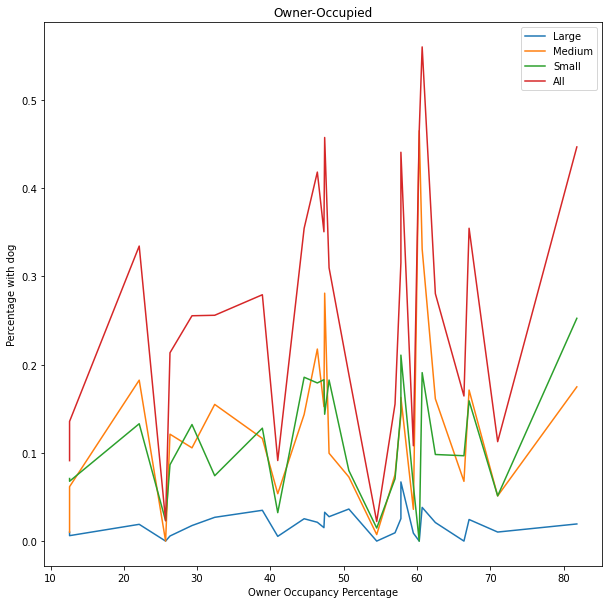

In [386]:
fig = plt.figure(figsize=(10.0,10.0))
plot_attribute(fig, 'DP04_0046PE', 'Owner-Occupied', 'Owner Occupancy Percentage')

plt.legend()
plt.show()

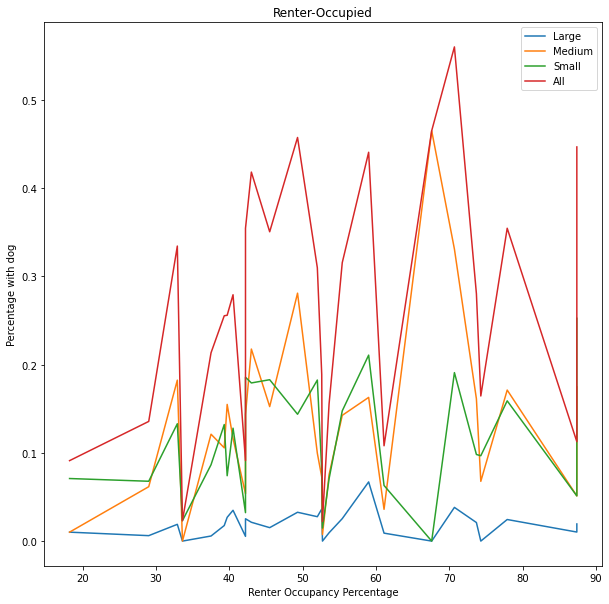

In [382]:
fig = plt.figure(figsize=(10.0,10.0))
plot_attribute(fig, 'DP04_0047PE', 'Renter-Occupied', 'Renter Occupancy Percentage')

plt.legend()
plt.show()

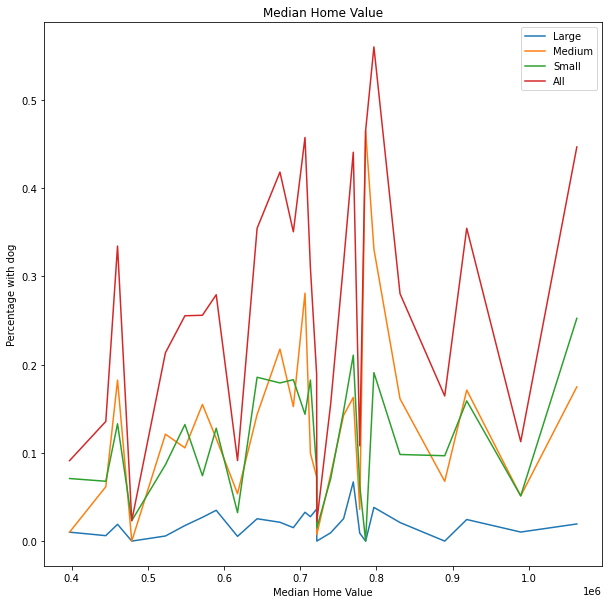

In [383]:
fig = plt.figure(figsize=(10.0,10.0))
plot_attribute(fig, 'DP04_0089E', 'Median Home Value', 'Median Home Value')

plt.legend()
plt.show()


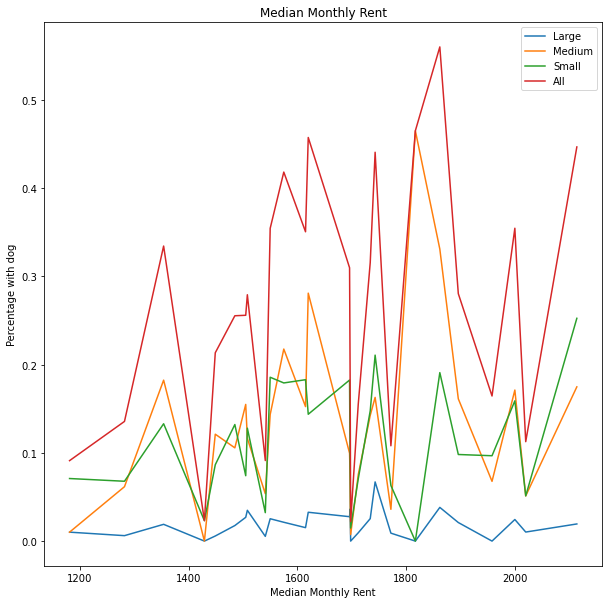

In [384]:
fig = plt.figure(figsize=(10.0,10.0))
plot_attribute(fig, 'DP04_0134E', 'Median Monthly Rent', 'Median Monthly Rent')

plt.legend()
plt.show()

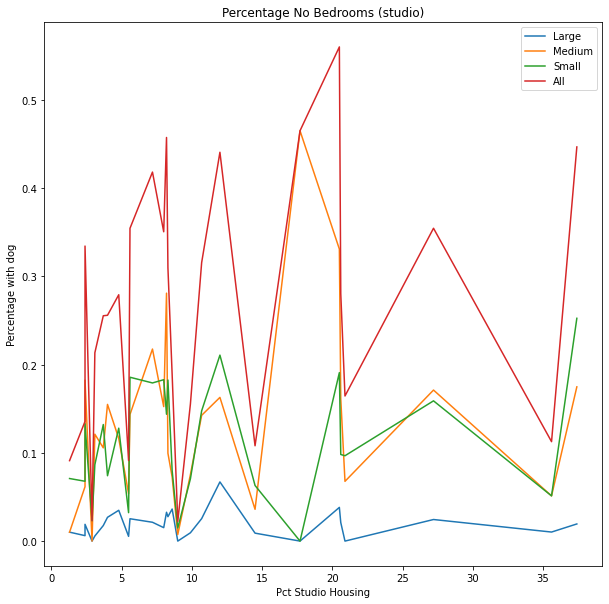

In [387]:
fig = plt.figure(figsize=(10.0,10.0))
plot_attribute(fig, 'DP04_0039PE', 'Percentage No Bedrooms (studio)', 'Pct Studio Housing')

plt.legend()
plt.show()

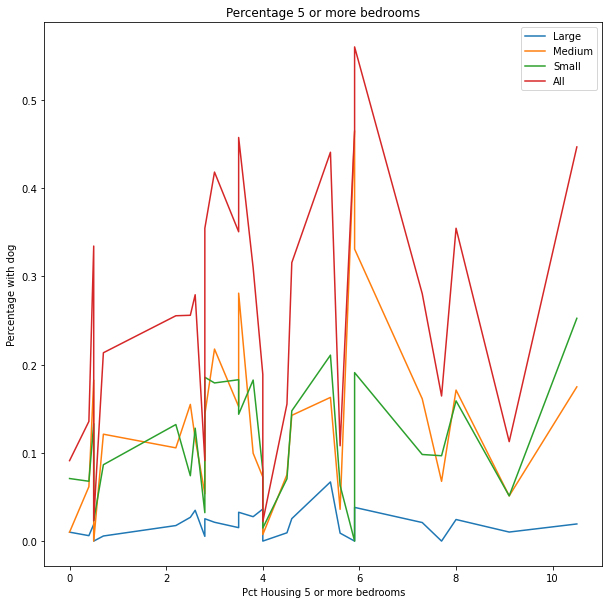

In [388]:
fig = plt.figure(figsize=(10.0,10.0))
plot_attribute(fig, 'DP04_0044PE', 'Percentage 5 or more bedrooms', 'Pct Housing 5 or more bedrooms')

plt.legend()
plt.show()